In [2]:
import pandas as pd 
import torch 
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader 
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt 

In [3]:
# Set random seeds for reproducibility 
torch.manual_seed(42)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [5]:
df = pd.read_csv("/home/subhamchakraborty/Default_download/fashion-mnist_train.csv")
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
df.shape

(60000, 785)

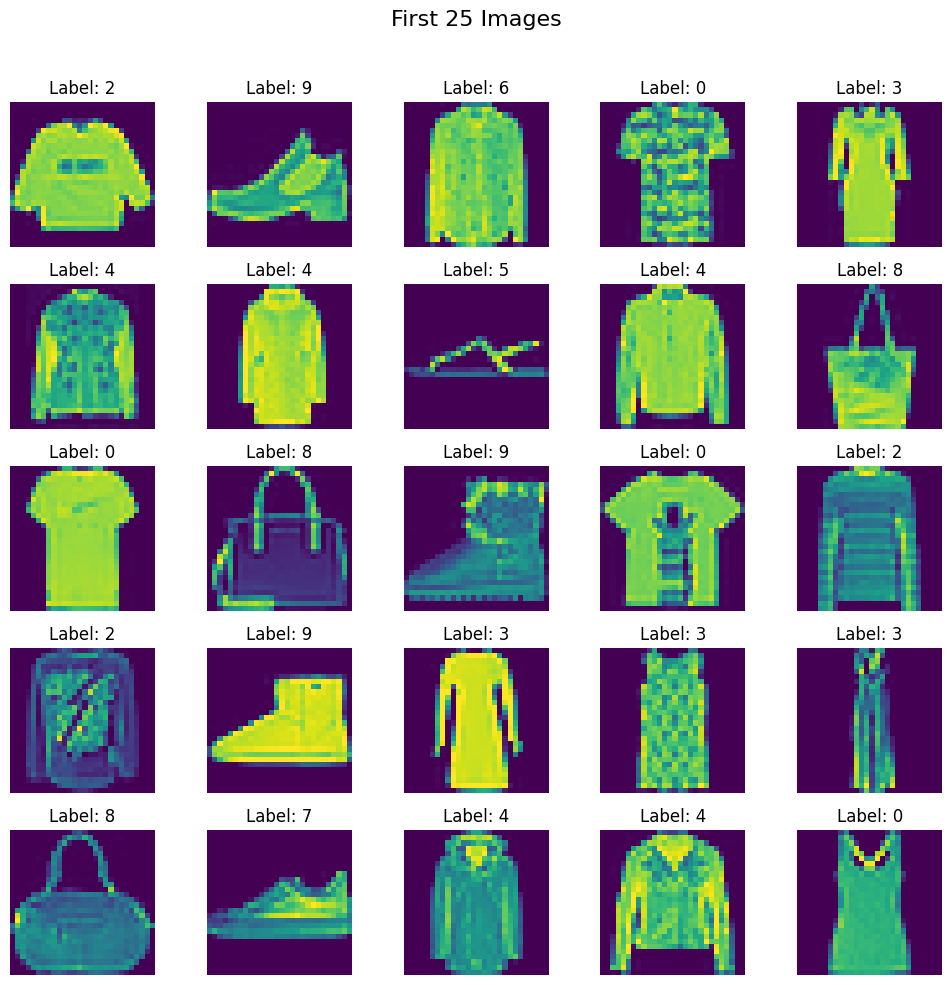

In [7]:
## Create a 4 x 4 grid of images 

fig, axes = plt.subplots(5, 5, figsize = (10, 10))
fig.suptitle("First 25 Images", fontsize = 16)

# Plot the first 16 images from the dataset 
for i, ax in enumerate(axes.flat):
    img = df.iloc[i, 1:].values.reshape(28, 28)  # Reshape to 28x28
    ax.imshow(img)  # Display in grayscale
    ax.axis('off')  # Remove axis for a cleaner look
    ax.set_title(f"Label: {df.iloc[i, 0]}")  # Show the label

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
plt.show()

In [8]:
## Train test split  

X = df.iloc[:,1:].values
y = df.iloc[:, 0].values

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [10]:
## Scaling the features 

X_train = X_train / 255.0
X_test = X_test/ 255.0

In [11]:
### Create CustomDataset class 

class CustomDataset(Dataset):

    def __init__(self, features, labels):

        self.features = torch.tensor(features, dtype = torch.float32) 
        self.labels = torch.tensor(labels, dtype = torch.long)

    def __len__(self):
        
        return len(self.features)
    
    def __getitem__(self, index):
        return self.features[index], self.labels[index]


In [12]:
### Create Train Dataset object 

train_dataset = CustomDataset(X_train, y_train)

In [13]:
### Create Test Dataset Object 

test_dataset = CustomDataset(X_test, y_test)

In [14]:
### Create Train and Test Dataloader 

train_loader = DataLoader(train_dataset, batch_size=32, shuffle = True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle = True, pin_memory=True)

In [15]:
class MyNN(nn.Module):

    def __init__(self, input_dim, output_dim, num_hidden_layers, neurons_per_layer):

        super().__init__()

        layers = []

        for i in range(num_hidden_layers):

            layers.append(nn.Linear(input_dim, neurons_per_layer))
            layers.append(nn.BatchNorm1d(neurons_per_layer))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.3))
            input_dim = neurons_per_layer

        layers.append(nn.Linear(neurons_per_layer, output_dim))

        self.model = nn.Sequential(*layers) # Asterisk for unpacking all individual layers 
    
    def forward(self, x):

        return self.model(x)

## Hyperparameter tunning (based on only num of hiddn layers and neurons per layer)

### Objective function

In [16]:
def objective(trial):

    # Next hyperparameter values from the search space 
    num_hidden_layers = trial.suggest_int("num_hidden_layers",1, 5)
    neurons_per_layer = trial.suggest_int("neurons_per_layers",8, 128, step = 8)

    # Model init 
    input_dim = 784
    output_dim = 10

    model = MyNN(input_dim, output_dim, num_hidden_layers, neurons_per_layer)
    model.to(device)

    # Params init 

    ### Set Learning rate and epochs 
    learning_rate  = 0.1
    epochs = 50

    # Optimizer selection 

    ### Loss Function  
    criterion = nn.CrossEntropyLoss()
    ### Optimizer 
    optimizer = optim.SGD(model.parameters(), lr = learning_rate)


    # Training loop 
    ### Training Loop 

    for epoch in range(epochs):

        for batch_features, batch_labels in train_loader:

            # Move the data to GPU
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

            # Forward Pass: 

            outputs  = model(batch_features)
            
            # Calculate Loss 

            loss = criterion(outputs, batch_labels)

            # Backward pass 
            optimizer.zero_grad()
            loss.backward()

            # Update gradients 
            optimizer.step()

    # Evaluation 

    model.eval()

    ### Evaluation code (on test data)

    total = 0
    correct = 0

    with torch.no_grad():

        for batch_features, batch_labels in test_loader:

            # Move the data to GPU     
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

            outputs = model(batch_features)

            _,predicted = torch.max(outputs,1)

            total = total + batch_labels.shape[0]

            correct = correct + (predicted == batch_labels).sum().item()

    accuracy = correct/total

    return accuracy 



In [17]:
!pip install optuna 

In [18]:
## Study Design  
import optuna 

study = optuna.create_study(direction = 'maximize')

[I 2025-03-11 11:13:50,799] A new study created in memory with name: no-name-22dbdc2c-57b9-4664-a782-ab1106158bdb


In [19]:
study.optimize(objective, n_trials = 10)

[I 2025-03-11 11:17:46,710] Trial 0 finished with value: 0.8918333333333334 and parameters: {'num_hidden_layers': 1, 'neurons_per_layers': 128}. Best is trial 0 with value: 0.8918333333333334.
[I 2025-03-11 11:22:29,809] Trial 1 finished with value: 0.89225 and parameters: {'num_hidden_layers': 2, 'neurons_per_layers': 96}. Best is trial 1 with value: 0.89225.
[I 2025-03-11 11:26:45,000] Trial 2 finished with value: 0.8911666666666667 and parameters: {'num_hidden_layers': 4, 'neurons_per_layers': 120}. Best is trial 1 with value: 0.89225.
[I 2025-03-11 11:31:30,953] Trial 3 finished with value: 0.8681666666666666 and parameters: {'num_hidden_layers': 5, 'neurons_per_layers': 40}. Best is trial 1 with value: 0.89225.
[I 2025-03-11 11:37:36,860] Trial 4 finished with value: 0.8604166666666667 and parameters: {'num_hidden_layers': 4, 'neurons_per_layers': 32}. Best is trial 1 with value: 0.89225.
[I 2025-03-11 11:44:12,699] Trial 5 finished with value: 0.8785 and parameters: {'num_hidden_

In [20]:
study.best_value 

0.89225

In [22]:
study.best_params 

{'num_hidden_layers': 2, 'neurons_per_layers': 96}